### Survival Analysis

In [1]:
%load_ext autoreload
%autoreload 2
%load_ext Cython
%reload_ext Cython

In [2]:
import sys
sys.path.append('..')
import warnings
def warn(message, category=None, stacklevel=1, source=None):
    pass

warnings.warn = warn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter
from diabetes_onset import survival_diabetes

#### Get the following datasets from running ```diabetes_surv_propens5.ipynb```

In [3]:
%%time
p = 'temp/'
treated0 = pd.read_pickle(p+'treated0.p').sort_values(by = ['PERS_ID', 'MYR']).reset_index(drop = True)
treated1 = pd.read_pickle(p+'treated1.p').sort_values(by = ['PERS_ID', 'MYR']).reset_index(drop = True)

random =  pd.read_pickle(p+'random.p').sort_values(by = ['PERS_ID', 'MYR']).reset_index(drop = True)
control0 = pd.read_pickle(p+'match0.p').sort_values(by = ['PERS_ID', 'MYR']).reset_index(drop = True)
control1 = pd.read_pickle(p+'match1.p').sort_values(by = ['PERS_ID', 'MYR']).reset_index(drop = True)

CPU times: user 1.62 s, sys: 1.56 s, total: 3.18 s
Wall time: 3.2 s


In [4]:
data = [treated0, treated1, random, control0, control1]
for d in data:
    d['Acute-bin'] = ((d['ALLOW_ER'] > 0) | (d['ALLOW_IP'] > 0)).astype(int)

In [5]:
%%time
onset = 'Acute-bin'
surv1 = treated0.groupby('PERS_ID').apply(survival_diabetes, onset = onset).reset_index(drop = True)
surv2 = treated1.groupby('PERS_ID').apply(survival_diabetes, onset = onset).reset_index(drop = True)

CPU times: user 2.23 s, sys: 0 ns, total: 2.23 s
Wall time: 2.23 s


In [6]:
%%time
surv3 = control0.groupby('PERS_ID').apply(survival_diabetes, onset = onset).reset_index(drop = True)
surv4 = control1.groupby('PERS_ID').apply(survival_diabetes, onset = onset).reset_index(drop = True)

CPU times: user 41.5 s, sys: 158 ms, total: 41.7 s
Wall time: 41.7 s


In [7]:
%%time
#surv5 = random.groupby('PERS_ID').apply(survival_diabetes).reset_index(drop = True)

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.96 µs


<div style="background:Aliceblue"> <h3>Fit Kaplan Meier Curves for Survival Analysis </br>
$P(T > t) = \prod_{t_i <t}\frac{n_i-d_i}{n_i}$ </br>
$n_i$: Remaining population before time $t_i$ </br>
$d_i$: Events (Diabetes Onsets) at time $t_i$
</h3>
</div>

In [8]:
from lifelines import CoxPHFitter 
from lifelines import WeibullFitter
from lifelines.statistics import logrank_test
from lifelines.plotting import add_at_risk_counts



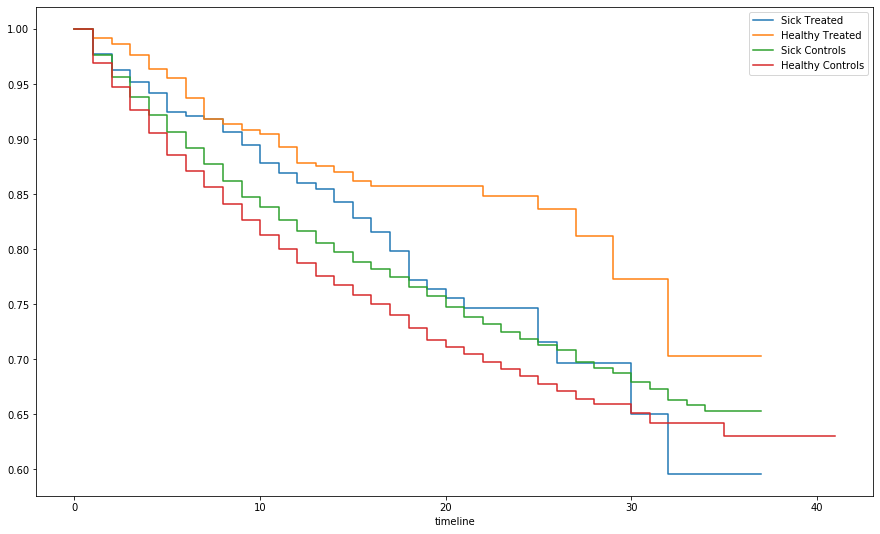

In [9]:
fig, ax = plt.subplots(1,1, figsize = (15,9))

kmf = KaplanMeierFitter()

kmf.fit(surv1['T'], event_observed=surv1.E, label="Sick Treated")
kmf.plot_survival_function(ax=ax,ci_show=False)

kmf.fit(surv2['T'], event_observed=surv2.E, label="Healthy Treated")
kmf.plot_survival_function(ax=ax,ci_show=False)

kmf.fit(surv3['T'], event_observed=surv3.E, label="Sick Controls")
kmf.plot_survival_function(ax=ax,ci_show=False)

kmf.fit(surv4['T'], event_observed=surv4.E, label="Healthy Controls")
kmf.plot_survival_function(ax=ax,ci_show=False)

#ax.set_xlim(0, 25)
#ax.set_ylim(0.94, 1)
fig.show()

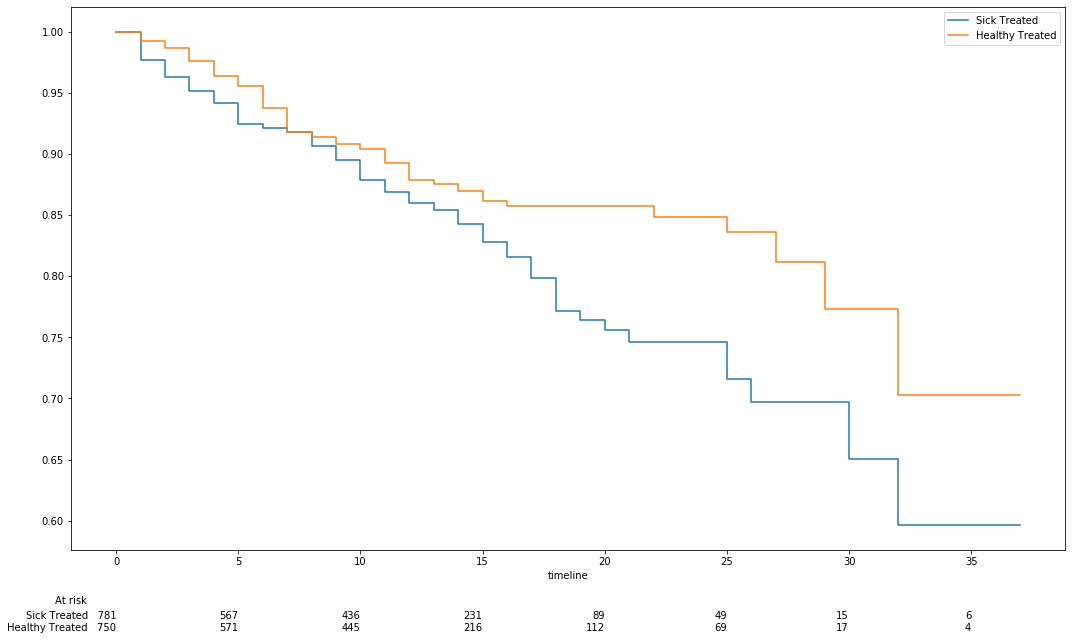

In [10]:
fig, ax = plt.subplots(1,1, figsize = (15,9))

kmf1 = KaplanMeierFitter()

kmf1 = kmf1.fit(surv1['T'], event_observed=surv1.E, label="Sick Treated")
ax = kmf1.plot_survival_function(ax=ax,ci_show=False)

kmf2 = KaplanMeierFitter()

kmf2 = kmf2.fit(surv2['T'], event_observed=surv2.E, label="Healthy Treated")
ax = kmf2.plot_survival_function(ax=ax,ci_show=False)

add_at_risk_counts(kmf1, kmf2, ax=ax)


plt.tight_layout()


In [11]:
results = logrank_test(surv1['T'], surv2['T'], event_observed_A=surv1.E, event_observed_B=surv2.E)
results.print_summary()


<lifelines.StatisticalResult>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1

---
 test_statistic    p  -log2(p)
           6.18 0.01      6.27


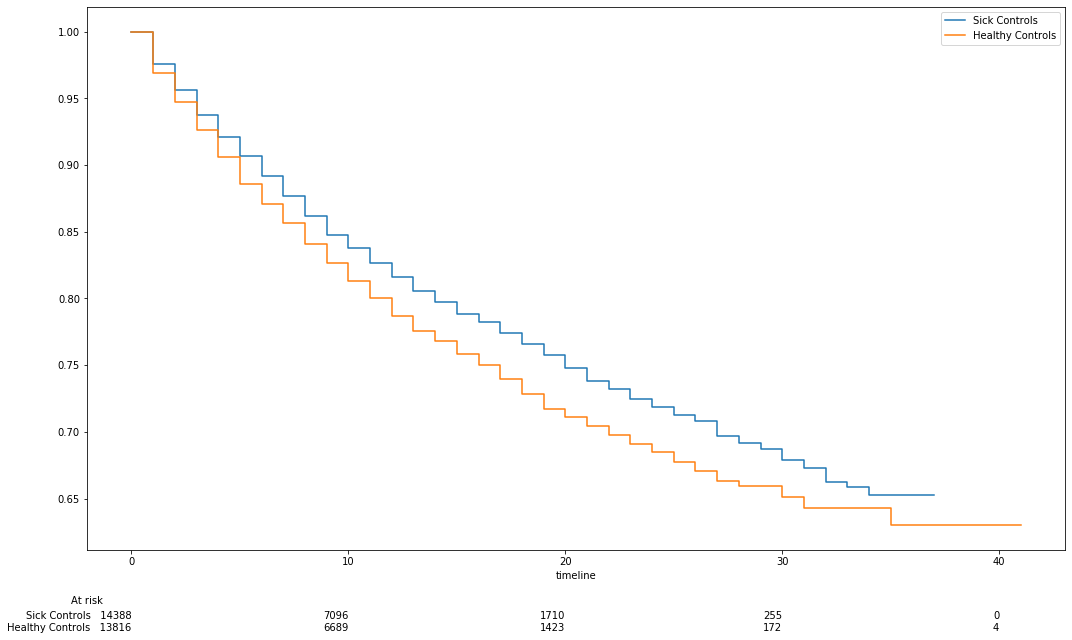

In [12]:
fig, ax = plt.subplots(1,1, figsize = (15,9))

kmf1 = KaplanMeierFitter()

kmf1 = kmf1.fit(surv3['T'], event_observed=surv3.E, label="Sick Controls")
ax = kmf1.plot_survival_function(ax=ax,ci_show=False)

kmf2 = KaplanMeierFitter()

kmf2 = kmf2.fit(surv4['T'], event_observed=surv4.E, label="Healthy Controls")
ax = kmf2.plot_survival_function(ax=ax,ci_show=False)

add_at_risk_counts(kmf1, kmf2, ax=ax)


plt.tight_layout()


In [13]:
results = logrank_test(surv3['T'], surv4['T'], event_observed_A=surv3.E, event_observed_B=surv4.E)
results.print_summary()

<lifelines.StatisticalResult>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1

---
 test_statistic      p  -log2(p)
          30.84 <0.005     25.09


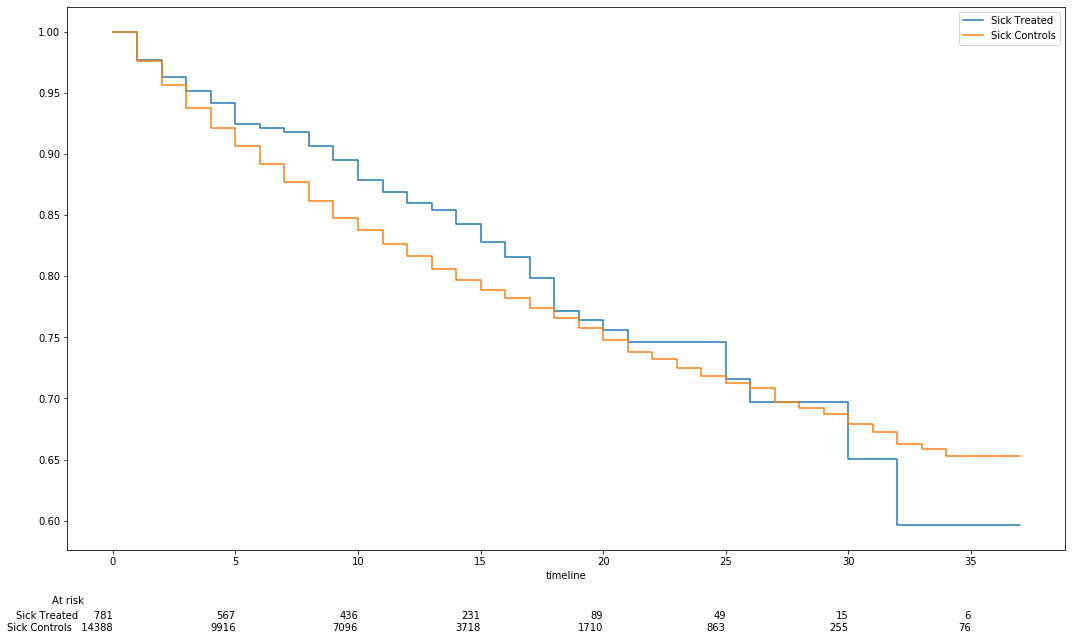

In [14]:
fig, ax = plt.subplots(1,1, figsize = (15,9))

kmf1 = KaplanMeierFitter()

kmf1 = kmf1.fit(surv1['T'], event_observed=surv1.E, label="Sick Treated")
ax = kmf1.plot_survival_function(ax=ax,ci_show=False)

kmf2 = KaplanMeierFitter()

kmf2 = kmf2.fit(surv3['T'], event_observed=surv3.E, label="Sick Controls")
ax = kmf2.plot_survival_function(ax=ax,ci_show=False)

add_at_risk_counts(kmf1, kmf2, ax=ax)


plt.tight_layout()


In [15]:
results = logrank_test(surv1['T'], surv3['T'], event_observed_A=surv1.E, event_observed_B=surv3.E)
results.print_summary()

<lifelines.StatisticalResult>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1

---
 test_statistic    p  -log2(p)
           3.81 0.05      4.30


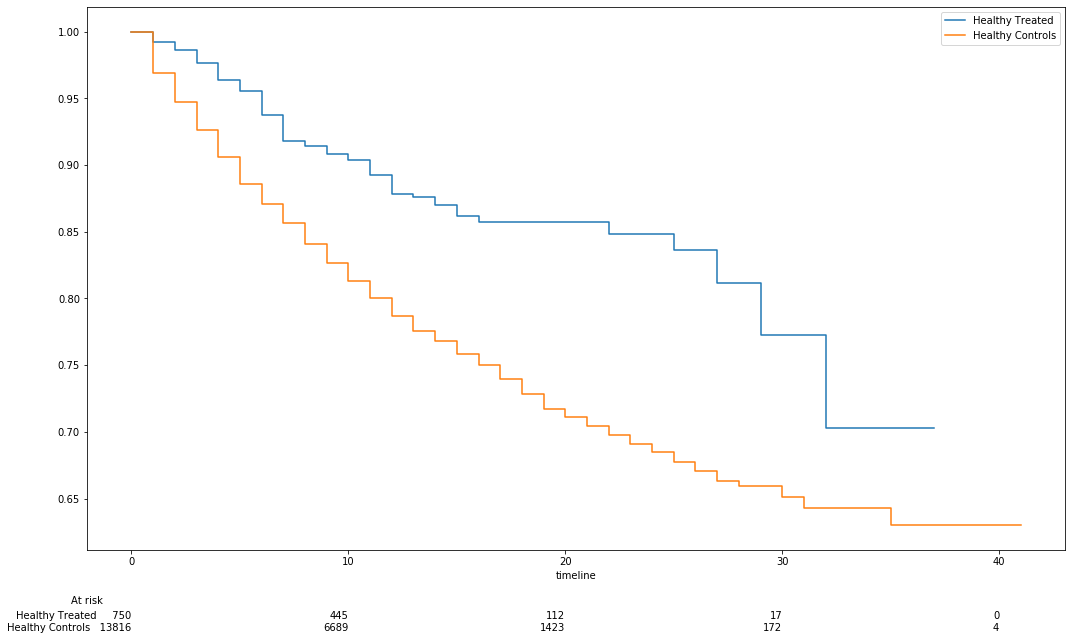

In [16]:
fig, ax = plt.subplots(1,1, figsize = (15,9))

kmf1 = KaplanMeierFitter()

kmf1 = kmf1.fit(surv2['T'], event_observed=surv2.E, label="Healthy Treated")
ax = kmf1.plot_survival_function(ax=ax,ci_show=False)

kmf2 = KaplanMeierFitter()

kmf2 = kmf2.fit(surv4['T'], event_observed=surv4.E, label="Healthy Controls")
ax = kmf2.plot_survival_function(ax=ax,ci_show=False)

add_at_risk_counts(kmf1, kmf2, ax=ax)


plt.tight_layout()


In [17]:
results = logrank_test(surv2['T'], surv4['T'], event_observed_A=surv2.E, event_observed_B=surv4.E)
results.print_summary()

<lifelines.StatisticalResult>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1

---
 test_statistic      p  -log2(p)
          39.74 <0.005     31.68


### Cox Proportional Hazards Model: Models the hazard function $h(t|x)$  
$h(t|x) = h_0(t)f(x)$  
where $h_0$ is the baseline hazard function depending only on time $t$  
and $f(x)$ modifies the hazard function dependent on a subject's covariates

In [18]:
from sklearn.preprocessing import MinMaxScaler

columns_to_match = ['AGE_AT_MIDMONTH', 'ALLOW_AMT','CC_TOBACCO', 'CC_PRESSURE', 'CC_OBESITY',
                   'CC_HYPERTENSION', 'CC_HYPOTHYROID', 'CC_DX_CNT', 'T', 'E']
surv11 = surv1.loc[:,columns_to_match]
surv21 = surv2.loc[:,columns_to_match]
surv31 = surv3.loc[:,columns_to_match]
surv41 = surv4.loc[:,columns_to_match]

columns_to_normalize = ['AGE_AT_MIDMONTH', 'ALLOW_AMT']
surv11[columns_to_normalize] = MinMaxScaler().fit_transform(surv11[columns_to_normalize].values)
surv21[columns_to_normalize] = MinMaxScaler().fit_transform(surv21[columns_to_normalize].values)
surv31[columns_to_normalize] = MinMaxScaler().fit_transform(surv31[columns_to_normalize].values)
surv41[columns_to_normalize] = MinMaxScaler().fit_transform(surv41[columns_to_normalize].values)


cpx1 = CoxPHFitter().fit(surv11, duration_col = 'T', event_col = 'E', step_size = 0.1, show_progress=True)
#cpx2 = CoxPHFitter().fit( surv21, duration_col = 'T', event_col = 'E', step_size = 0.1,show_progress=True)

cpx3 = CoxPHFitter().fit(surv31, duration_col = 'T', event_col = 'E', step_size = 0.1, show_progress=True)
cpx4 = CoxPHFitter().fit(surv41, duration_col = 'T', event_col = 'E', step_size = 0.1, show_progress=True)


Iteration 25: norm_delta = 0.05057, step_size = 1.0000, ll = -653.67975, newton_decrement = 0.00000, seconds_since_start = 0.1Convergence completed after 25 iterations.
Iteration 17: norm_delta = 0.00000, step_size = 1.0000, ll = -21243.61397, newton_decrement = 0.00000, seconds_since_start = 0.2Convergence completed after 17 iterations.
Iteration 17: norm_delta = 0.00000, step_size = 1.0000, ll = -22882.24805, newton_decrement = 0.00000, seconds_since_start = 0.2Convergence completed after 17 iterations.


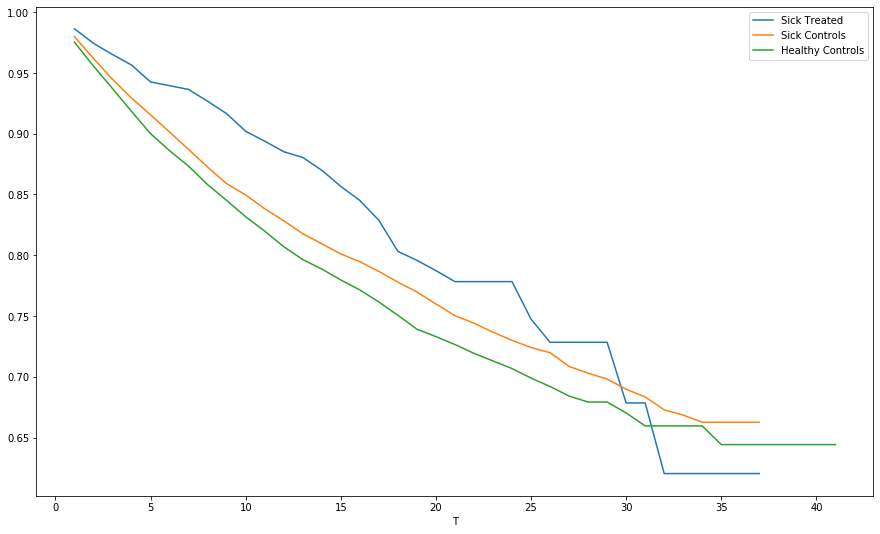

In [19]:
fig, ax = plt.subplots(1,1, figsize = (15,9))

ax = cpx1.baseline_survival_.plot(ax = ax)
cpx3.baseline_survival_.plot(ax = ax)
cpx4.baseline_survival_.plot(ax = ax)
ax.legend(['Sick Treated', 'Sick Controls', 'Healthy Controls'])
plt.show()

### Coefficient Plot

### Sick Treated

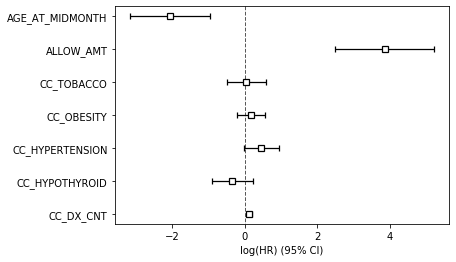

In [20]:
cols = ['AGE_AT_MIDMONTH', 'ALLOW_AMT','CC_TOBACCO', 'CC_OBESITY',
                   'CC_HYPERTENSION', 'CC_HYPOTHYROID', 'CC_DX_CNT']
cpx1.plot(columns = cols)
plt.show()

### Sick Controls

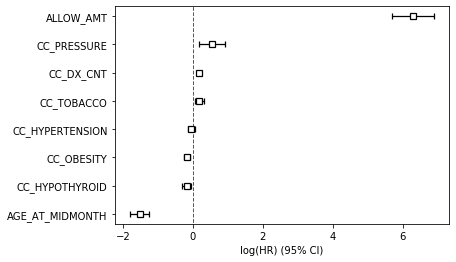

In [21]:
cpx3.plot()
plt.show()

### healthy Controls

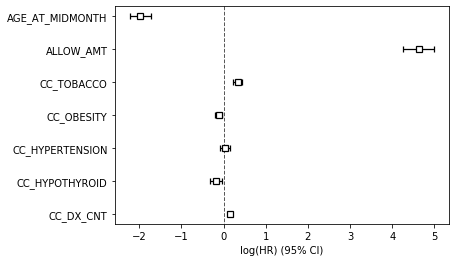

In [22]:
cpx4.plot(columns = cols)
plt.show()

## 1. Healthy - Matched Controls plus Treated  
## 2. Sick - Matched Controls plus Treated
<h3><span style="color:red">to study the treatment effect</span></h3>

In [23]:
surv1['Treatment'] = 1
surv2['Treatment'] = 1

surv3['Treatment'] = 0
surv4['Treatment'] = 0

columns_to_match = ['AGE_AT_MIDMONTH', 'ALLOW_AMT','CC_TOBACCO', 'CC_PRESSURE', 'CC_OBESITY',
                   'CC_HYPERTENSION', 'CC_HYPOTHYROID', 'CC_DX_CNT', 'T', 'E', 'Treatment']

columns_to_normalize = ['AGE_AT_MIDMONTH', 'ALLOW_AMT']


sick = pd.concat((surv1, surv3), axis = 0, ignore_index = True )[columns_to_match]
healthy = pd.concat((surv2, surv4), axis = 0, ignore_index = True )[columns_to_match]
alltogether = pd.concat((surv1, surv2, surv3, surv4), axis = 0, ignore_index = True )[columns_to_match]
sick[columns_to_normalize] = MinMaxScaler().fit_transform(sick[columns_to_normalize].values)
healthy[columns_to_normalize] = MinMaxScaler().fit_transform(healthy[columns_to_normalize].values)
alltogether[columns_to_normalize] = MinMaxScaler().fit_transform(alltogether[columns_to_normalize].values)

cpxS = CoxPHFitter().fit(sick, duration_col = 'T', event_col = 'E', step_size = 0.1, show_progress=True)
cpxH = CoxPHFitter().fit(healthy, duration_col = 'T', event_col = 'E', step_size = 0.1, show_progress=True)
cpxAll = CoxPHFitter().fit(alltogether, duration_col = 'T', event_col = 'E', step_size = 0.1, show_progress=True)

Iteration 17: norm_delta = 0.00000, step_size = 1.0000, ll = -22371.97353, newton_decrement = 0.00000, seconds_since_start = 0.2Convergence completed after 17 iterations.
Iteration 17: norm_delta = 0.00000, step_size = 1.0000, ll = -23717.95961, newton_decrement = 0.00000, seconds_since_start = 0.2Convergence completed after 17 iterations.
Iteration 17: norm_delta = 0.00000, step_size = 1.0000, ll = -49754.49973, newton_decrement = 0.00000, seconds_since_start = 0.3Convergence completed after 17 iterations.


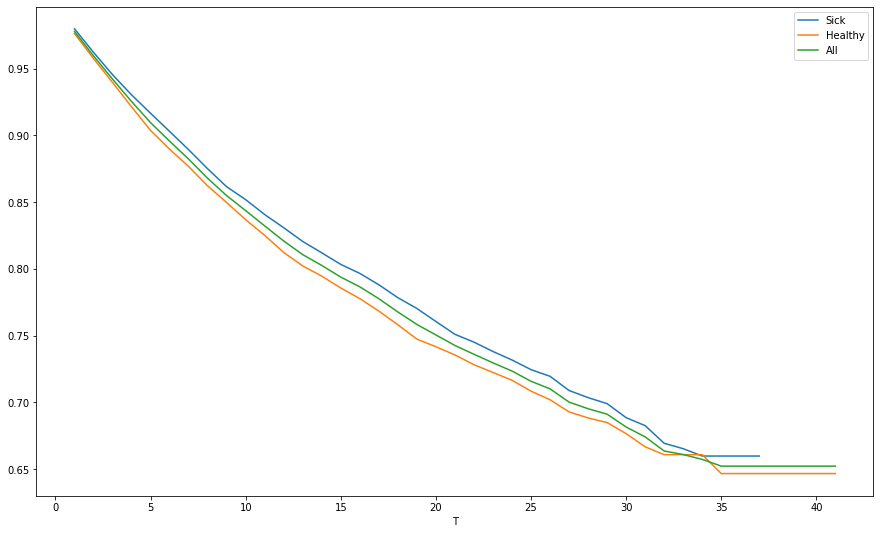

In [24]:
fig, ax = plt.subplots(1,1, figsize = (15,9))

ax = cpxS.baseline_survival_.plot(ax = ax)
cpxH.baseline_survival_.plot(ax = ax)
cpxAll.baseline_survival_.plot(ax = ax)

ax.legend(['Sick', 'Healthy', 'All'])
plt.show()

### Sick

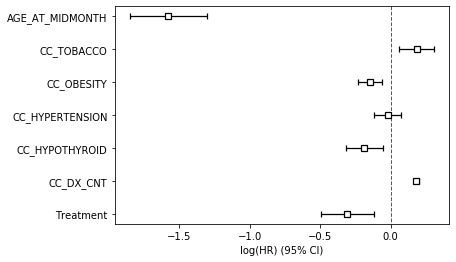

In [25]:
cols = ['AGE_AT_MIDMONTH', 'CC_TOBACCO', 'CC_OBESITY',
                   'CC_HYPERTENSION', 'CC_HYPOTHYROID', 'CC_DX_CNT', 'Treatment']
cpxS.plot(columns = cols)
plt.show()

### Healthy

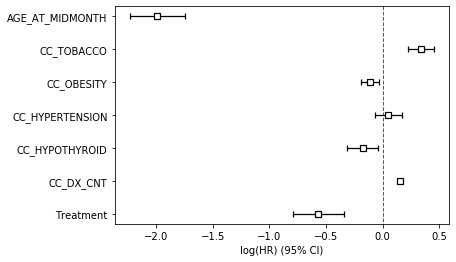

In [26]:
cpxH.plot(columns = cols)
plt.show()

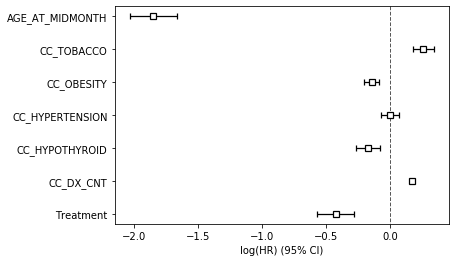

In [27]:
cpxAll.plot(columns = cols)
plt.show()

### All

In [28]:
cpxS.params_

AGE_AT_MIDMONTH   -1.575244
ALLOW_AMT          6.380215
CC_TOBACCO         0.183354
CC_PRESSURE        0.523239
CC_OBESITY        -0.144793
CC_HYPERTENSION   -0.021123
CC_HYPOTHYROID    -0.186713
CC_DX_CNT          0.182903
Treatment         -0.308349
dtype: float64

In [29]:
cpxH.params_

AGE_AT_MIDMONTH   -1.988122
ALLOW_AMT          4.655761
CC_TOBACCO         0.339304
CC_PRESSURE       -0.109086
CC_OBESITY        -0.113050
CC_HYPERTENSION    0.050063
CC_HYPOTHYROID    -0.176481
CC_DX_CNT          0.151324
Treatment         -0.568658
dtype: float64

In [30]:
cpxAll.params_

AGE_AT_MIDMONTH   -1.845923
ALLOW_AMT          7.034765
CC_TOBACCO         0.259348
CC_PRESSURE        0.318009
CC_OBESITY        -0.142986
CC_HYPERTENSION    0.000050
CC_HYPOTHYROID    -0.172699
CC_DX_CNT          0.173673
Treatment         -0.425335
dtype: float64

### Fit All Populations Together with the State (Healthy-Sick) As a Variable)

In [31]:
surv1['State'] = 0
surv2['State'] = 1

surv3['State'] = 0
surv4['State'] = 1

#set columns
columns_to_match = ['AGE_AT_MIDMONTH', 'ALLOW_AMT','CC_TOBACCO', 'CC_PRESSURE', 'CC_OBESITY',
                   'CC_HYPERTENSION', 'CC_HYPOTHYROID', 'CC_DX_CNT', 'T', 'E', 'Treatment', 'State']
columns_to_normalize = ['AGE_AT_MIDMONTH', 'ALLOW_AMT']

#make data
population = pd.concat((surv1, surv2, surv3, surv4), axis = 0, ignore_index = True )[columns_to_match]
population['StatexTreat'] = population.State.values*population.Treatment.values

population[columns_to_normalize] = MinMaxScaler().fit_transform(population[columns_to_normalize].values)

#fit model
cpxP = CoxPHFitter().fit(population, duration_col = 'T', event_col = 'E', step_size = 0.1, show_progress=True)


Iteration 17: norm_delta = 0.00000, step_size = 1.0000, ll = -49749.65730, newton_decrement = 0.00000, seconds_since_start = 0.3Convergence completed after 17 iterations.


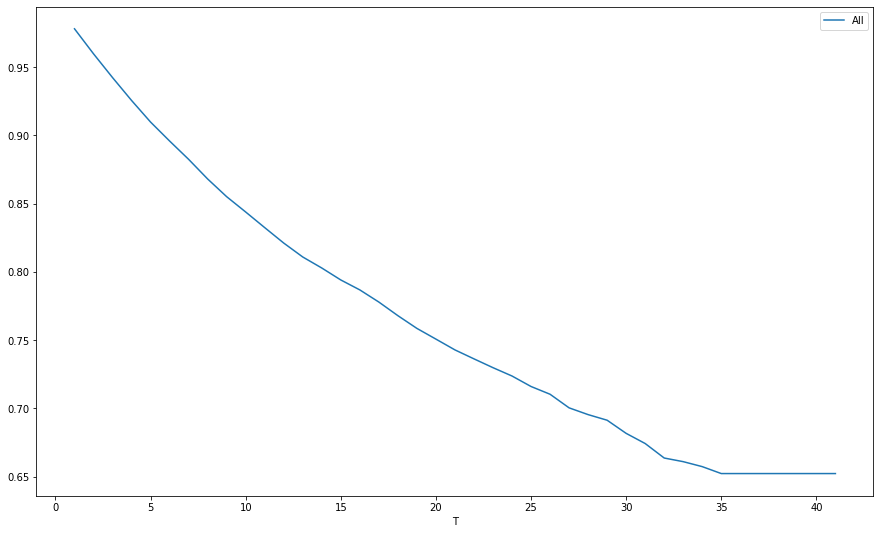

In [32]:
fig, ax = plt.subplots(1,1, figsize = (15,9))

ax = cpxP.baseline_survival_.plot(ax = ax)
ax.legend(['All'])
plt.show()

### Box Plots of covariates weights (State = 1 healthy)

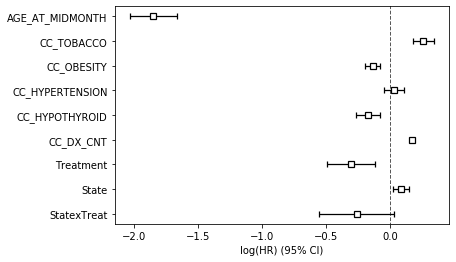

In [33]:
cols = ['AGE_AT_MIDMONTH', 'CC_TOBACCO', 'CC_OBESITY',
                   'CC_HYPERTENSION', 'CC_HYPOTHYROID', 'CC_DX_CNT', 'Treatment', 'State', 'StatexTreat']
cpxP.plot(columns = cols)
plt.show()

In [34]:
cpxP.params_

AGE_AT_MIDMONTH   -1.849911
ALLOW_AMT          7.106869
CC_TOBACCO         0.261223
CC_PRESSURE        0.317132
CC_OBESITY        -0.135652
CC_HYPERTENSION    0.031330
CC_HYPOTHYROID    -0.173595
CC_DX_CNT          0.169699
Treatment         -0.304574
State              0.086484
StatexTreat       -0.261414
dtype: float64